# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

Загрузим данные по каждому региону.

In [2]:
data_geo_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
data_geo_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
data_geo_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

Посмотрим на основные данные по каждому региону: количество скважин, набор признаков их отличающих, типы данных.

In [3]:
 data_geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data_geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Посмотрим на описательную статистику датасета.

In [5]:
data_geo_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Проверим наличие явных дубликатов (вместе с идентификатором скважины).

In [6]:
data_geo_0.duplicated().sum()

0

Проверим наличие пропусков.

In [7]:
data_geo_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Удалим столбец с id скважины, так как данная информация не является значимой для будущей модели.

In [8]:
data_geo_0 = data_geo_0.drop(['id'], axis=1)

Проверим корреляцию признаков, чтобы избежать проблемы мультиколлинеарности.

In [9]:
data_geo_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Построим гисторамму распределения целевого признака по региону.

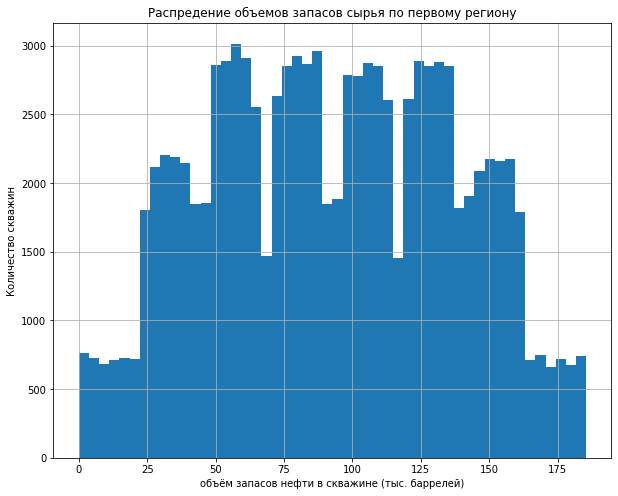

In [10]:
data_geo_0['product'].hist(figsize=(10,8),bins=50)
plt.xlabel('объём запасов нефти в скважине (тыс. баррелей)')
plt.ylabel('Количество скважин')
plt.title('Распредение объемов запасов сырья по первому региону')
plt.show()

Проделаем все шаги анализа для следующих двух регионов.

In [11]:
data_geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [12]:
data_geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
data_geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [14]:
data_geo_1.duplicated().sum()

0

In [15]:
data_geo_1 = data_geo_1.drop(['id'], axis=1)

In [16]:
data_geo_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


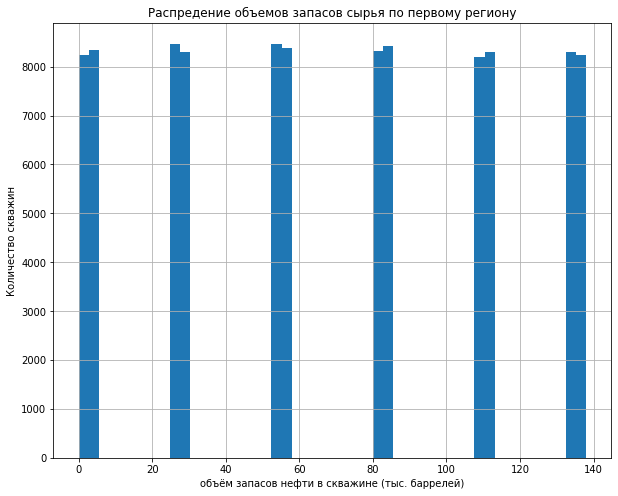

In [17]:
data_geo_1['product'].hist(figsize=(10,8),bins=50)
plt.xlabel('объём запасов нефти в скважине (тыс. баррелей)')
plt.ylabel('Количество скважин')
plt.title('Распредение объемов запасов сырья по первому региону')
plt.show()

In [18]:
data_geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [19]:
data_geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [20]:
data_geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [21]:
data_geo_2.duplicated().sum()

0

In [22]:
data_geo_2 = data_geo_2.drop(['id'], axis=1)

In [23]:
data_geo_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


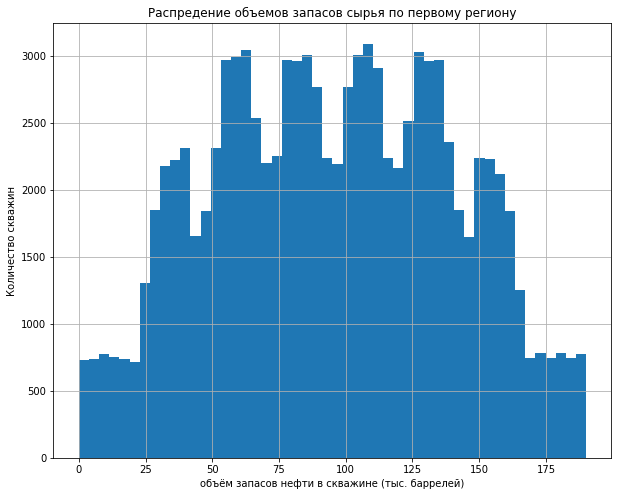

In [24]:
data_geo_2['product'].hist(figsize=(10,8),bins=50)
plt.xlabel('объём запасов нефти в скважине (тыс. баррелей)')
plt.ylabel('Количество скважин')
plt.title('Распредение объемов запасов сырья по первому региону')
plt.show()

<div class="alert alert-info"> 
<b> ВЫВОД:</b>

Выборка по каждому из трех регионов состоит из 100000 объектов. Есть информация по 5 признакам.
из них значимыми для модели могут быть 4 (включая, целевой признак).

Все признаки количественные, включая целевой. Целевой признак: объем нефти в скважине. 
Таким образом, перед моделью будет стоять задача регрессии.

Согласно описательной статистике признаки имеют различный разброс и нуждаются в масштабировании.

В выборке не обнаружены полные дубликаты и пропуски.

Признаки проверены на мультиколлинеарность, проблема не обнаружена.

Согласно гистораммам распределения значений целевого признака для первого и третьего признака можно говорить о распредении близком к нормальному.
Для второго региона имеет место дискретное распределение.

</div>

## Обучение и проверка модели

Разделим выборки по каждому из регионов на обучающую и валидационную в соотношении 75%:25%

In [25]:
# функция для разбивки датасета на обучающую и валидационную выборки

def split(data, target):
    features = data.drop([target], axis = 1)
    target = data[target]
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, \
                                                                                  test_size=0.25, random_state=12345)
    
    return features_train, features_valid, target_train, target_valid

In [26]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split(data_geo_0, 'product')

In [27]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = split(data_geo_1, 'product')

In [28]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = split(data_geo_2, 'product')

Проверим размеры получившихся выборок на примере первого региона.

In [29]:
features_train_0.shape

(75000, 3)

In [30]:
features_valid_0.shape

(25000, 3)

Проведем масштабирование признаков для первого и третьего региона с помощью Standardscaler (так как распределение целевого признака близко к нормальному), для второго региона используем MinMaxScaler, чтобы сохранить изначальное распределение.

In [31]:
scaler = StandardScaler()
features_train_0 = scaler.fit_transform(features_train_0) 
features_valid_0 = scaler.transform(features_valid_0)

In [32]:
scaler = MinMaxScaler()
features_train_1 = scaler.fit_transform(features_train_1) 
features_valid_1 = scaler.transform(features_valid_1)

In [33]:
scaler = StandardScaler()
features_train_2 = scaler.fit_transform(features_train_2) 
features_valid_2 = scaler.transform(features_valid_2)

Проведем моделирование при помощи линейной регрессии, оценим качество модели метрикой RMSE для каждого из регионов.

In [34]:
# функция построения модели линейной регрессии и оценки ее качества на валидационной выборке

def LinReg(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    df = pd.DataFrame({'real_product' : target_valid, 'predicted_product' : predictions_valid},\
                      columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predictions_valid, squared=False)
    return df, rmse

In [35]:
df_0, rmse_0 = LinReg(features_train_0, target_train_0, features_valid_0, target_valid_0)

In [36]:
df_0.head(10)

,real_product,predicted_product
71751,10.038645,95.894952
80493,114.551489,77.572583
2655,132.603635,77.892640
53233,169.072125,90.175134
91141,122.325180,70.510088
9539,37.735331,69.127076
8482,139.227191,125.106759
30284,72.491987,87.643849
66393,11.465993,86.035871
99584,110.562031,98.655311


In [37]:
print('Средний запас предсказанного сырья по первому региону =', df_0['predicted_product'].mean(), 'тыс.баррелей')
print('RMSE модели по первому региону =', rmse_0)

Средний запас предсказанного сырья по первому региону = 92.59256778438035 тыс.баррелей
RMSE модели по первому региону = 37.5794217150813


In [38]:
df_1, rmse_1 = LinReg(features_train_1, target_train_1, features_valid_1, target_valid_1)

In [39]:
print('Средний запас предсказанного сырья по второму  региону =', df_1['predicted_product'].mean(), 'тыс.баррелей')
print('RMSE модели по второму региону =', rmse_1)

Средний запас предсказанного сырья по второму  региону = 68.72854689544603 тыс.баррелей
RMSE модели по второму региону = 0.893099286775617


In [40]:
df_2, rmse_2 = LinReg(features_train_2, target_train_2, features_valid_2, target_valid_2)

In [41]:
print('Средний запас предсказанного сырья по третьему региону =', df_2['predicted_product'].mean(), 'тыс.баррелей')
print('RMSE модели по третьему региону =', rmse_2)

Средний запас предсказанного сырья по третьему региону = 94.96504596800489 тыс.баррелей
RMSE модели по третьему региону = 40.02970873393434


<div class="alert alert-info"> 
<b> ВЫВОД:</b>

На данном этапе были разделены выборки каждого из регионов на обучающую и валидационную части в соотношении 75%:25%.
Затем проведено масштабирование признаков при помощи StandardScaler и MinMaxScaler.
Построены модели линейной регрессии, проведена оценка качества при помощи метрики RMSE.

Наибольший средний запас сырья наблюдаем в третьем регионе, затем - первый регион, наименьшие средние показатели у второго региона.
Однако по данному региону модель делает наиболее точные предсказания (минимальное значение среднеквадратической ошибки).
Кроме того, для данного региона наблюдается дискретная форма распределения значений целевого признака. Есть выбросы в объемах запасов сырья, показатели могут сильно отличаться от среднего.

RMSE модели линейной регрессии для первого и третьего регионов достаточно высокие, особенно в сравнении с данной метрикой на втором регионе.
    
Расчитаем прибыль и риски каждого из регионов для окончательного выбора региона.

</div>

## Подготовка к расчёту прибыли

Создадим отдельные переменные для ключевых значений расчетов. BUDGET - совокупный бюджет на разработку скважин в регионе, TOTAL_POINTS - общее количество исследуемых скважин, BEST_POINTS - количество лучших по объему сырья скважин, которые будут разрабатываться, BARREL_PRICE - цена за один баррель нефти.

In [42]:
BUDGET = 10000000000
TOTAL_POINTS = 500
BEST_POINTS = 200
BARREL_PRICE = 450

Рассчитаем достаточный объём сырья для безубыточной разработки скважины.

In [43]:
min_product_per_point = BUDGET/(BEST_POINTS*BARREL_PRICE*1000)

In [44]:
print(f'Минимально достаточный объем сырья для безубыточной разработки новой скважины =\
{min_product_per_point: .2f} тыс. баррелей')

Минимально достаточный объем сырья для безубыточной разработки новой скважины = 111.11 тыс. баррелей


Сравним полученный объём сырья со средним запасом в каждом регионе.

In [45]:
mean_product_geo_0 = data_geo_0['product'].mean()
mean_product_geo_1 = data_geo_1['product'].mean()
mean_product_geo_2 = data_geo_2['product'].mean()
print(f'Средний фактический запас нефти в первом регине: {mean_product_geo_0 : .2f} тыс. баррелей')
print(f'Средний фактический запас нефти во втором регине: {mean_product_geo_1 : .2f} тыс. баррелей')
print(f'Средний фактический запас нефти в третьем регине: {mean_product_geo_2 : .2f} тыс. баррелей')

Средний фактический запас нефти в первом регине:  92.50 тыс. баррелей
Средний фактический запас нефти во втором регине:  68.83 тыс. баррелей
Средний фактический запас нефти в третьем регине:  95.00 тыс. баррелей


<div class="alert alert-info"> 
<b> ВЫВОД:</b>

На данном этапе осуществлена подготовка к расчету прибыли потенциально разрабатываемых скважин: 
введены необходимые переменные, рассчитан минимальный объем сырья для безубыточной разработки скважины,
а также рассчитаны средние показатели запаса сырья в скважине в каждом из регионов.
    
Полученные результаты средних значений запасов ниже минимального безубыточного объема по каждому из регионов. 
При этом в первом и третьем регионах средний запас сырья в скважинах близок к минимально безубыточному, 
для второго региона средний фактический запас гораздо ниже минимально достаточного запаса для нулевой прибыли.

Результаты говорят о том, что необходимо выбирать скважины для разработки неслучайным образом, а например, при помощи предварительного исследования их признаков и предсказания при помощи модели потенциального запаса сырья в скважине, который будет выше безубыточного.

На следующем этапе проведем расчет средней прибыли, доверительного интервала для показателя прибыли и рисков для каждого региона.


</div>

## Расчёт прибыли и рисков 

Создадим функцию расчета прибыли разрабатываемых скважин:

    - Выберем скважины с максимальными значениями предсказаний
    - Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям
    - Рассчитаем прибыль для полученного объёма сырья

In [46]:
# функция расчета прибыли

def profit_oil(target, predictions, points):
    predictions_sorted = predictions.sort_values(ascending=False)
    profit = target[predictions_sorted.index][:points].sum()*BARREL_PRICE*1000 - BUDGET
    return profit

Посчитаем риски и прибыль для каждого региона:

    - создадим функцию Bootstrap с 1000 выборок
    - будем отбирать 500 скважин по целевым и предсказанным объемам сырья
    - для 200 лучших по предсказанным объемам сырья скважинам будем считать прибыль
    - получим распределение прибыли, расчитаем ее среднее значение и 95%-й доверительный интервал
    - расчитаем уровень риска для каждого из регионов(как процент отрицательных прибылей в полученном распределении прибыли)

In [47]:
def bootstrap(target, predictions):
    state = np.random.RandomState(12345)
    values = []
    lost = 0
    for i in range(1000):
        target_subsample = target.sample(n = TOTAL_POINTS, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        values.append(profit_oil(target_subsample, predictions_subsample, BEST_POINTS))
       
    values = pd.Series(values)
    lower = values.quantile(.025)
    upper = values.quantile(.975)

    mean = values.mean()
    risk = values[values<0].count()/len(values)
    
    return mean, lower, upper, risk

In [48]:
mean_0, lower_0, upper_0, risk_0 = bootstrap(df_0['real_product'], df_0['predicted_product'])

In [49]:
print('Первый регион')
print(f'Средняя прибыль по региону: {mean_0/1000 : .2f} тыс.руб.')
print(f'95% доверительный интервал от {lower_0/1000:.2f} до {upper_0/1000:.2f} тыс.руб.')
print(f'Процент риска {risk_0:.2%}')

Первый регион
Средняя прибыль по региону:  425938.53 тыс.руб.
95% доверительный интервал от -102090.09 до 947976.35 тыс.руб.
Процент риска 6.00%


In [50]:
mean_1, lower_1, upper_1, risk_1 = bootstrap(df_1['real_product'], df_1['predicted_product'])

In [51]:
print('Второй регион')
print(f'Средняя прибыль по региону: {mean_1/1000 : .2f} тыс.руб.')
print(f'95% доверительный интервал от {lower_1/1000:.4f} до {upper_1/1000:.4f} тыс.руб.')
print(f'Процент риска {risk_1:.2%}')

Второй регион
Средняя прибыль по региону:  515222.77 тыс.руб.
95% доверительный интервал от 68873.2254 до 931547.5913 тыс.руб.
Процент риска 1.00%


In [52]:
mean_2, lower_2, upper_2, risk_2 = bootstrap(df_2['real_product'], df_2['predicted_product'])

In [53]:
print('Третий регион')
print(f'Средняя прибыль по региону: {mean_2/1000: .4f} тыс.руб.')
print(f'95% доверительный интервал от {lower_2/1000:.4f} до {upper_2/1000:.4f} тыс.руб.')
print(f'Процент риска {risk_2:.2%}')

Третий регион
Средняя прибыль по региону:  435008.3628 тыс.руб.
95% доверительный интервал от -128880.5473 до 969706.9542 тыс.руб.
Процент риска 6.40%


<div class="alert alert-info"> 
<b> ВЫВОД:</b>

Используя технику Bootstrap с 1000 выборок удалось посмотреть на распределение прибыли от добычи нефти в каждом из регионов.
Судя по результатам, наиболее перспективным оказался второй регион. В этом регионе наблюдаем максимальную среднюю прибыль и самый низкий процент риска (1%).
 
Пороговое значение уровня риска 2,5%, ни первый, ни третий регион не подходят под данный критерий. Кроме того, среднее значение прибыли для данных регионов ниже по сравнению со вторым регионом.
    
Доверительный интервал для значения прибыли от разработки скважин для второго региона показывает,что даже в случае неудачного выбора скважин для разработки, компания не понесет убытки с 95% вероятностью.
    
</div>

## Итоговый вывод

В ходе данного проекта были выполнены следующие шаги:

   - изучены данные по каждому из трех регионов, выявлены закономерности, проведена подготовка к моделированию
    
   - построена модель линейной регрессии и проведена оценка ее качества
   - сделаны предварительные выводы о том, что наилучшим образом модель работает на втором регионе: RMSE модели минимальна
   - проведен расчет точки безубыточности и сравнение ее со средними показателями объемов сырья в скважине по каждому из регионов
   - сделан вывод о том, что минимальный безубыточный объем добычи нефти выше любого среднего запаса сырья в каждом из регионов, что подтверждает факт необходимости неслучайного выбора потенциального места разработки
   - с помощью техники Bootstrap построено распределение показателя прибыли по регионам, расчитан 95%-й доверительный интервал для прибыли, оценен уровень риска
   - второй регион выбран как наиболее перспективный для разработки месторождений: несмотря на самые низкие средние показатели запасов сырья, данный регион характеризуется  максимальной прибылью, минимальным риском и сложностью уйти в убыток даже при неудачном выборе скважин. Это еще раз подтверждает факт важности граммотного построения модели с максимальной метрикой качества для предсказания объемов запасов сырья в скважинах.


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован